# Clustering Analysis via Regression
In this notebook, we analyze the clustering conducted in `clustering.ipynb` to get a better idea of walkability and bikeability discomfort. To conduct this, we do the following:
1. Apply linear regression to the whole dataset, with the `Cluster` column as the target variable.
2. Determine the weights of the linear regression model.

In [78]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [140]:
gdf_edge_bike = gpd.read_file('geofabrik_merged_data (tentative)/geofabrik_bike_graph_edges_w_EDSAaccidents.geojson')
gdf_edge_walk = gpd.read_file('geofabrik_merged_data (tentative)/geofabrik_walk_graph_edges_w_EDSAaccidents.geojson') 
df_bike = pd.read_csv('features/bike_cluster_full.csv')
df_walk = pd.read_csv('features/walk_cluster_full.csv')

In [141]:
df_bike_geo = df_bike.merge(gdf_edge_bike, how='inner', on=['u','v','key']).reset_index()
df_walk_geo = df_walk.merge(gdf_edge_walk, how='inner', on=['u','v','key']).reset_index()

In [142]:
gdf_bike = gpd.GeoDataFrame(df_bike_geo)
gdf_walk = gpd.GeoDataFrame(df_walk_geo)

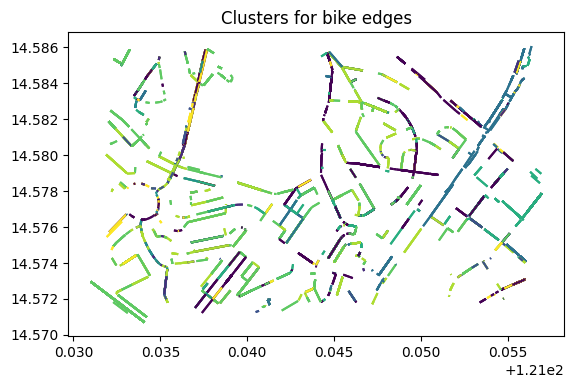

In [143]:
gdf_bike.plot(column='Cluster')
plt.title('Clusters for bike edges')
plt.show()

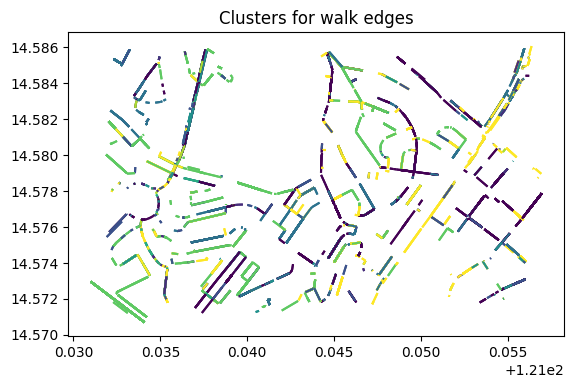

In [144]:
gdf_walk.plot(column='Cluster')
plt.title('Clusters for walk edges')
plt.show()

# Applying Linear Regression

In [145]:
# Numerical variables are already scaled
cat_vars = 'scene_label highway surface'.split(' ')

In [146]:
# One-Hot Encoding for categorical columns, and scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cat_vars) 
    ], 
    remainder='passthrough'
)

# Step 2: Pipeline
def perform_linear_regression(df, target_col):
    # Ensure X remains a DataFrame for column operations
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Define the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('linear_regression', LinearRegression())
    ])

    # Fit the pipeline to the data
    pipeline.fit(X, y)

    # Get the coefficients/weights and intercept
    weights = pipeline.named_steps['linear_regression'].coef_
    intercept = pipeline.named_steps['linear_regression'].intercept_

    # Get feature names after encoding to match coefficients
    encoded_feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()
    
    # Create a summary of weights
    coef_summary = pd.DataFrame({
        'Feature': encoded_feature_names,
        'Coefficient': weights
    })
    coef_summary.sort_values('Coefficient', ascending=False, inplace=True)

    return coef_summary, intercept, pipeline

In [147]:
X_bike = df_bike.drop(columns=['u','v','key'])
X_walk = df_walk.drop(columns=['u','v','key'])

In [148]:
coef_bike, intercept_bike, pipeline_bike = perform_linear_regression(X_bike, 'Cluster')
coef_walk, intercept_walk, pipeline_walk = perform_linear_regression(X_walk, 'Cluster')

In [149]:
coef_bike.head(10)

,Feature,Coefficient
7,cat__scene_label_residential_neighborhood,2.365648e+11
5,cat__scene_label_highway,2.365648e+11
1,cat__scene_label_bridge,2.365648e+11
3,cat__scene_label_driveway,2.365648e+11
0,cat__scene_label_alley,2.365648e+11
4,cat__scene_label_forest_road,2.365648e+11
8,cat__scene_label_street,2.365648e+11
2,cat__scene_label_crosswalk,2.365648e+11
6,cat__scene_label_railroad_track,2.365648e+11
34,remainder__has_lit,2.359009e-01


In [150]:
coef_walk.head(10)

,Feature,Coefficient
24,cat__surface_paving_stones,1.027499e+13
23,cat__surface_concrete,1.027499e+13
25,cat__surface_nan,1.027499e+13
22,cat__surface_asphalt,1.027499e+13
30,remainder__obstruction_density,8.413825e-01
31,remainder__sidewalk_ratio,5.262844e-01
29,remainder__has_bicycle,1.850275e-01
26,remainder__has_crosswalk,5.834089e-02
34,remainder__road_condition,0.000000e+00
32,remainder__cycling_lane_coverage,-1.116648e-02
